In [1]:
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\jayaw\AppData\Local\sagemaker\sagemaker\config.yaml


In [2]:
load_dotenv()

True

In [3]:
sm_boto3 = boto3.client("sagemaker")   # Create a low-level SageMaker client using boto3
sess = sagemaker.Session()             # Create a SageMaker session using the high-level SageMaker SDK
region = sess.boto_session.region_name # Get the AWS region associated with the current session
bucket = "student-sleep-quality-prediction-bucket-sagemaker"  # Define the name of your S3 bucket
print("Using bucket", bucket)          # Output the name of the bucket being used

Using bucket student-sleep-quality-prediction-bucket-sagemaker


## Load Dataset

In [4]:
df = pd.read_csv('student_sleep_patterns.csv')
df.head()

,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
0,1,24,Other,2nd Year,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,Male,1st Year,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,Male,4th Year,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,Other,4th Year,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,Male,4th Year,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01


## Exploratory Data Analysis (EDA)

In [5]:
df.shape

(500, 14)

In [6]:
df.isnull().sum()

Student_ID             0
Age                    0
Gender                 0
University_Year        0
Sleep_Duration         0
Study_Hours            0
Screen_Time            0
Caffeine_Intake        0
Physical_Activity      0
Sleep_Quality          0
Weekday_Sleep_Start    0
Weekend_Sleep_Start    0
Weekday_Sleep_End      0
Weekend_Sleep_End      0
dtype: int64

In [7]:
df['Sleep_Quality'].value_counts()

Sleep_Quality
1     66
6     57
9     55
3     54
10    50
2     46
4     46
7     45
5     41
8     40
Name: count, dtype: int64

Text(0, 0.5, 'Count')

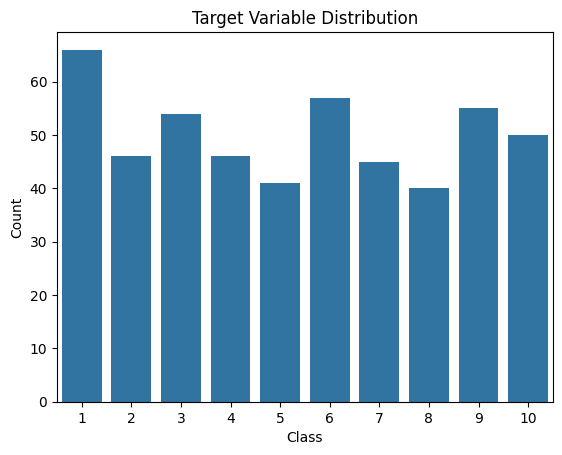

In [8]:
sns.countplot(x='Sleep_Quality', data=df)
plt.title("Target Variable Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

In [9]:
df.columns

Index(['Student_ID', 'Age', 'Gender', 'University_Year', 'Sleep_Duration',
       'Study_Hours', 'Screen_Time', 'Caffeine_Intake', 'Physical_Activity',
       'Sleep_Quality', 'Weekday_Sleep_Start', 'Weekend_Sleep_Start',
       'Weekday_Sleep_End', 'Weekend_Sleep_End'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Student_ID           500 non-null    int64  
 1   Age                  500 non-null    int64  
 2   Gender               500 non-null    object 
 3   University_Year      500 non-null    object 
 4   Sleep_Duration       500 non-null    float64
 5   Study_Hours          500 non-null    float64
 6   Screen_Time          500 non-null    float64
 7   Caffeine_Intake      500 non-null    int64  
 8   Physical_Activity    500 non-null    int64  
 9   Sleep_Quality        500 non-null    int64  
 10  Weekday_Sleep_Start  500 non-null    float64
 11  Weekend_Sleep_Start  500 non-null    float64
 12  Weekday_Sleep_End    500 non-null    float64
 13  Weekend_Sleep_End    500 non-null    float64
dtypes: float64(7), int64(5), object(2)
memory usage: 54.8+ KB


## Data Preprocessing

In [11]:
df.drop('Student_ID', inplace=True, axis=1)

In [12]:
TARGET = "Sleep_Quality"

In [13]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Apply LabelEncoder to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [14]:
X = df.drop(columns=[TARGET])  # Features (all except target)
y = df[TARGET]                 # Target variable

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

In [16]:
[print(f"{a.shape} \n") for a in (X_train, y_train, X_test, y_test)]

(425, 12) 

(425,) 

(75, 12) 

(75,) 



[None, None, None, None]

In [17]:
train_df = pd.DataFrame(X_train)
train_df[TARGET] = y_train

test_df = pd.DataFrame(X_test)
test_df[TARGET] = y_test

In [18]:
train_df.to_csv("train-V1.csv", index=False)
test_df.to_csv("test-V1.csv", index=False)

In [19]:
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = os.getenv('AWS_DEFAULT_REGION')

In [20]:
## send data to S3. Sagemaker will take the data for trainign from s3
sk_prefix="sagemaker/student-sleep-quality/sklearncontainer"
trainpath=sess.upload_data(path='train-V1.csv',bucket=bucket,key_prefix=sk_prefix)
testpath=sess.upload_data(path='test-V1.csv',bucket=bucket,key_prefix=sk_prefix)

print(trainpath)
print(testpath)

s3://student-sleep-quality-prediction-bucket-sagemaker/sagemaker/student-sleep-quality/sklearncontainer/train-V1.csv
s3://student-sleep-quality-prediction-bucket-sagemaker/sagemaker/student-sleep-quality/sklearncontainer/test-V1.csv
